In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
%matplotlib inline
pd.options.mode.chained_assignment = None

### EM Algorithm for Miss Data in Linear Regression Model
EM Algorithm is an iterative method for imputing missing data, censored data or latent variables. In some occassion the algorithm can be used for clustering. In this demonstration, I will try to apply EM algorithm to fill in the missing values in a linear regression model. The missing values are imputed by its conditional expectation and throughout the iteration, the log-likelihood is increasing. The iterative scheme is terminated when it signals sign of convergence. The convergence can be measured by the L2-norm or L1-norm of the difference between the parameter of current iteration and that of preceeding iterations.

In this example, there are 60 data points in `ex4.1.txt`. Variables include response variables `y` and independent variables `x1` and `x2`. Among those 60 data points, the last 15 data points have missing values in variable `x2`. Our goal is to apply EM algorithm to impute those missing values.

EM Algorithm is typically comprised of 3 steps. Based on the context of this example, the procedures are highligted as follows:
1. Initialization: The 15 missing values are initialially set to be 0. Regression parameters are estimated by MLE on the complete data
2. E-step: Based on the current parameter estimates, update the values of "missing X2" by its conditional expectation
3. M-step: Based on the updated values of X2, update the regression parameters by MLE on the complete data
4. Repeat step 2 and step 3 iteratively

In [2]:
txt_file = 'ex4.1.txt'
data = pd.read_csv(txt_file, sep="\t", header = None)
data.columns = ['x1', 'x2', 'y']

In [10]:
def fit_lm(data):
    n = len(data)
    # Fit a OLS model on complete data
    complete_lm = sm.ols(formula = 'y ~ x1 + x2',
                         data = data).fit()
    return complete_lm
    
def get_params(lm):
    n = lm.nobs
    # Get regression betas
    params = np.array(lm.params)
    betas_n = len(params)
    # Include sigma
    params = np.insert(params, betas_n, np.sqrt(lm.ssr / (n)))
    return params

# Input truncated data
def get_llf(data, params):
    sigma = params[-1]
    n = len(data)
    y = np.array(data.y, dtype = pd.Series)
    x1 = np.array(data.x1, dtype = pd.Series)
    x2 = np.array(data.x2, dtype = pd.Series)
    linear_sum = params[0] + params[1] * x1 + params[2] * x2
    ss = sum((y - linear_sum)**2)
    llf = -0.5*n*np.log(2*np.pi) - n*np.log(sigma) - 0.5*ss/(sigma**2)
    return llf

def get_norm(params_1, params_2):
    return np.linalg.norm(params_1 - params_2, ord = 1)

def update_NA(data, betas):
    idx = len(data) - 15
    for i in range(15):
        y = data.loc[idx + i, 'y']
        x1 = data.loc[idx + i, 'x1']
        data.loc[idx + i, 'x2'] = (y - betas[0] - betas[1]*x1) / betas[2]

In [11]:
def EM_Algo(data, iter_limit = 999):
    n = len(data)
    cnt = 0
    trunc_llf_list = []
    complete_llf_list = []
    params_list = []
    # Initialization
    params = np.array([2, 2, 2, 2])
    prev_params = np.array([0, 0, 0, 0])
    while (get_norm(params, prev_params) > 10e-6) and (cnt != iter_limit):
        cnt += 1
        prev_params = params
        # M-step
        # Don't need to fit trunc_lm!!!
        complete_lm = fit_lm(data)
        params = get_params(complete_lm)
        betas, sigma = params[:3], params[-1]
        # Store log-likelihood
        trunc_llf = get_llf(data.head(n-15), params)
        complete_llf = complete_lm.llf
        trunc_llf_list.append(trunc_llf)
        complete_llf_list.append(complete_llf)
        # Store parameters
        params_list.append(params)
        # E-step
        update_NA(data, betas)
    return data, trunc_llf_list, complete_llf_list, params_list, cnt

### Evolution of Imputed X2

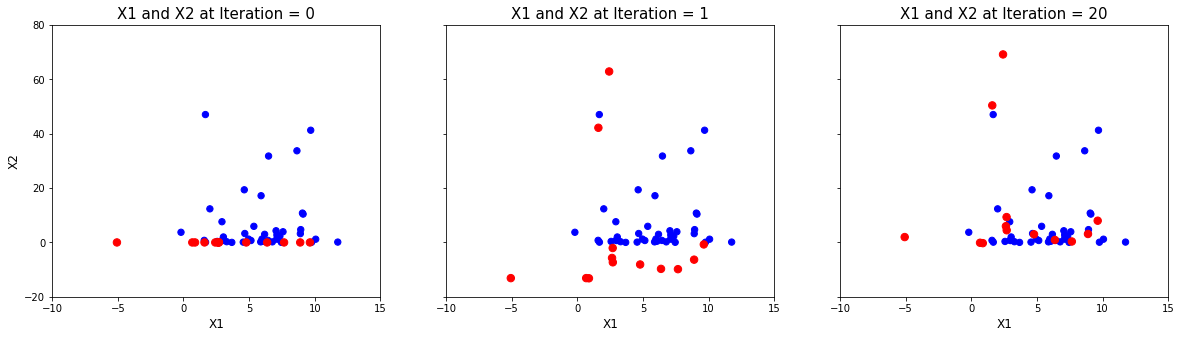

In [12]:
# Store data points at iteration = 0, 5, 20
data_iter_list = []
iter_list = [0, 1, 20]
marker_str = '.'*45 + 'o'
size_list = [40]*45 + [55]*15
for iter_l in iter_list:
    x, trunc_llf_list, complete_llf_list, params_list, cnt = EM_Algo(data.copy(), iter_limit = iter_l)
    data_iter_list.append(x)

f, (ax1, ax2, ax3) = plt.subplots(1, 3 ,sharey=True, figsize = (20, 5))
color_list = ['blue'] * 45 + ['red'] * 15
ax_list = [ax1, ax2, ax3]
for tmp_data, ax, iter_num in zip(data_iter_list, ax_list, iter_list):
    ax.scatter(tmp_data.x1, tmp_data.x2, s = size_list, c = color_list)
    ax.set_xlim(-10, 15)
    ax.set_ylim(-20, 80)
    ax.set_title('X1 and X2 at Iteration = {}'.format(iter_num), fontdict={'fontsize': 15})
    ax.set_xlabel('X1', fontdict={'fontsize': 12})
ax1.set_ylabel('X2', fontdict={'fontsize': 12});

* Red dots represent data points with missing values in X2. Notice their movements over iterations
* Blue dots represent data points without missing values. They keep static over iterations
* The graphs are rescaled so that a few of outlier points are not visible
* The algorithm converge after 30 iterations

### Evolution of Log-likelihood

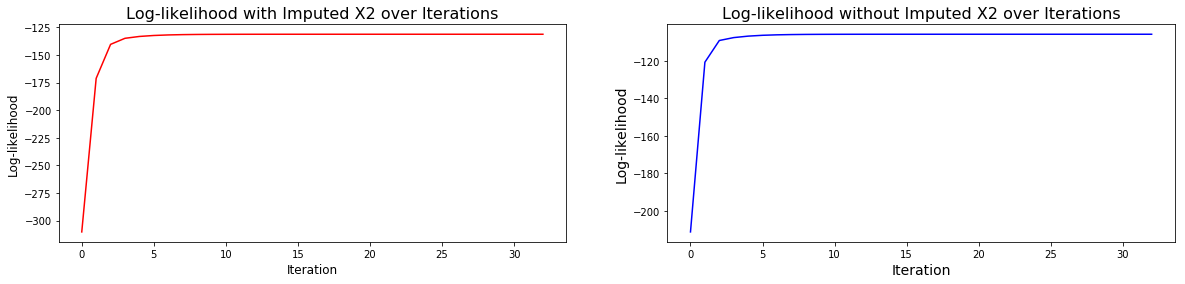

In [14]:
x, trunc_llf_list, complete_llf_list, params_list, cnt = EM_Algo(data.copy(), iter_limit = 100)
f, (ax1, ax2) = plt.subplots(1, 2 , figsize = (20, 4))
ax1.plot(complete_llf_list, color = 'red')
ax1.set_title('Log-likelihood with Imputed X2 over Iterations', fontdict={'fontsize': 16})
ax1.set_xlabel('Iteration', fontdict={'fontsize': 12})
ax1.set_ylabel('Log-likelihood', fontdict={'fontsize': 12});
ax2.plot(trunc_llf_list, color = 'blue')
ax2.set_title('Log-likelihood without Imputed X2 over Iterations', fontdict={'fontsize': 16})
ax2.set_xlabel('Iteration', fontdict={'fontsize': 14})
ax2.set_ylabel('Log-likelihood', fontdict={'fontsize': 14});

* Both truncated log-likelihood and complete log-likelihood increases over iteration
* Both log-likelihood converges at around 30 iterations

### Evolution of Parameters

In [15]:
params_df = pd.DataFrame(params_list, columns = ['beta0', 'beta1', 'beta2', 'sigma'])

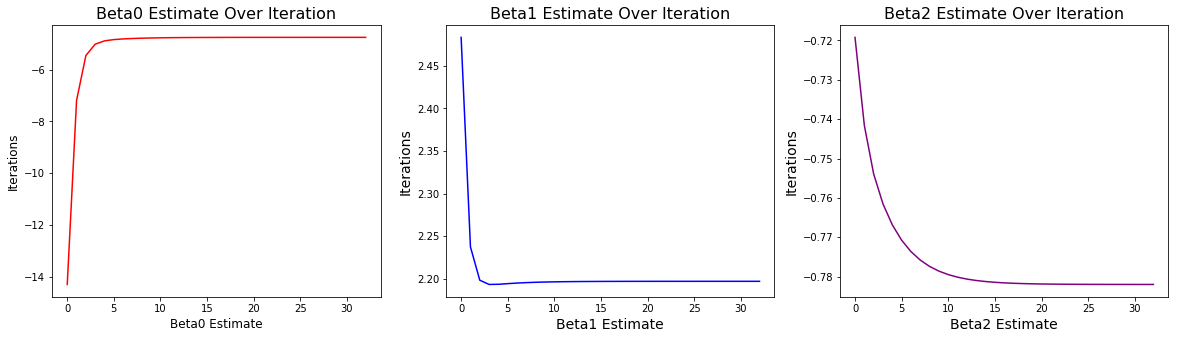

In [16]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3 , figsize = (20, 5))
ax1.plot(params_df.beta0, color = 'red')
ax1.set_title('Beta0 Estimate Over Iteration', fontdict={'fontsize': 16})
ax1.set_xlabel('Beta0 Estimate', fontdict={'fontsize': 12})
ax1.set_ylabel('Iterations', fontdict={'fontsize': 12});
ax2.plot(params_df.beta1, color = 'blue')
ax2.set_title('Beta1 Estimate Over Iteration', fontdict={'fontsize': 16})
ax2.set_xlabel('Beta1 Estimate', fontdict={'fontsize': 14})
ax2.set_ylabel('Iterations', fontdict={'fontsize': 14})
ax3.plot(params_df.beta2, color = 'purple')
ax3.set_title('Beta2 Estimate Over Iteration', fontdict={'fontsize': 16})
ax3.set_xlabel('Beta2 Estimate', fontdict={'fontsize': 14})
ax3.set_ylabel('Iterations', fontdict={'fontsize': 14});

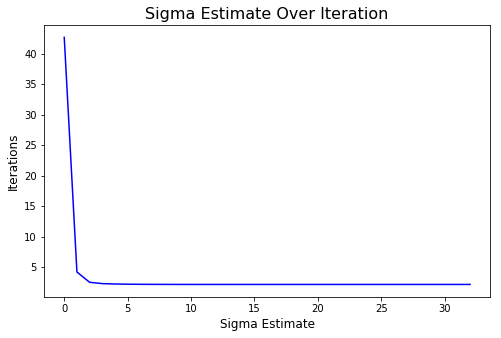

In [17]:
f, ax = plt.subplots(figsize = (8, 5))
ax.plot(params_df.sigma, color = 'blue')
ax.set_title('Sigma Estimate Over Iteration', fontdict={'fontsize': 16})
ax.set_xlabel('Sigma Estimate', fontdict={'fontsize': 12})
ax.set_ylabel('Iterations', fontdict={'fontsize': 12});